In [32]:
import pandas as pd
from openpyxl import load_workbook
import re
from unicodedata import normalize
import seaborn as sns
import matplotlib.pyplot as plt

In [78]:
import warnings
warnings.filterwarnings("ignore")

In [34]:
# https://www.mapa.gob.es/es/estadistica/temas/estadisticas-alimentacion/s482021_tcm30-381939.xlsx
file_path = "s482021_tcm30-381939.xlsx"
workbook = load_workbook(filename=file_path, data_only=True)

In [35]:
df_list = []
workbook.remove(workbook['Hoja1'])

# Recorrer todas las hojas
for sheet_name in workbook.sheetnames:
    ws = workbook[sheet_name]

    # https://stackoverflow.com/questions/74185338/how-can-i-extract-a-table-from-many-excel-documents-to-pandas
    for row in ws.iter_rows():
        for cell in row:
            if not cell.border.bottom.style:
                try:
                    cell.value = None
                except:
                    continue

    df = pd.DataFrame(ws.values).dropna(how='all', axis=0).dropna(how='all', axis=1).reset_index(drop=True)
    df.columns = df.iloc[0]
    df = df.drop(0).reset_index(drop=True)

    # Añadir 'YEAR'
    df['YEAR'] = sheet_name
    df['TIPO'] = ''
    df_list.append(df)

In [36]:
# categoricas
tipos = ['ORIGEN', 'MERCASA', 'DESTINO']

for df in df_list:
  indices_producto = df[df['productos'].str.contains('productos', case=False, na=False)].index
  indices_producto = indices_producto.append(pd.Index([df.index[-1]+1]))
  df.loc[0:indices_producto[0]-1, 'TIPO'] = tipos[0]
  df.loc[indices_producto[0]:indices_producto[1]-1, 'TIPO'] = tipos[1]
  if len(indices_producto) > 2:
    df.loc[indices_producto[1]:indices_producto[2], 'TIPO'] = tipos[2]

In [37]:
df = pd.concat(df_list, ignore_index=True)

In [39]:
# eliminar las cabeceras
df = df[df['productos']!='productos']

In [40]:
#df[df[df.columns[df.columns.str.startswith('S')]].isna().all(axis=1)]
columnas_s = df.columns[df.columns.str.startswith('S')]
filas_con_nan_en_s = df[columnas_s].isna().all(axis=1)
df = df[~filas_con_nan_en_s]

In [41]:
df['productos'] = df['productos'].str.replace('Cebolla grano de oro', 'Cebolla')

In [47]:
#https://es.stackoverflow.com/questions/135707/c%C3%B3mo-puedo-reemplazar-las-letras-con-tildes-por-las-mismas-sin-tilde-pero-no-l
def acentos(texto):
  texto = re.sub(
        r"([^cn\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f]))|c(?!\u0327(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1",
        normalize( "NFD", texto), 0, re.I
    )
  s = normalize( 'NFC', texto)
  texto = texto.replace('*', '')
  texto = texto.rstrip()
  return texto
df['productos'] = df['productos'].apply(acentos)

In [49]:
for column in df.columns:
    if column.startswith('S'):
        # Reemplazar los valores no numéricos por NaN y convertir a tipo float
        df[column] = pd.to_numeric(df[column], errors='coerce')

In [52]:
weeks_mapping = {
    "Enero": list(range(1, 5)),
    "Febrero": list(range(5, 9)),
    "Marzo": list(range(9, 14)),
    "Abril": list(range(14, 18)),
    "Mayo": list(range(18, 22)),
    "Junio": list(range(22, 27)),
    "Julio": list(range(27, 31)),
    "Agosto": list(range(31, 35)),
    "Septiembre": list(range(35, 40)),
    "Octubre": list(range(40, 44)),
    "Noviembre": list(range(44, 48)),
    "Diciembre": list(range(48, 54)),  # Incluye S53 si está
}

# Crear un nuevo DataFrame con columnas base
columnas_base = ['productos', 'Unidades', 'YEAR', 'TIPO']
df_base = df[columnas_base].copy()

# Calcular la media mensual por fila
for mes, semanas in weeks_mapping.items():
    columnas_semanas = [f"S {i}" for i in semanas if f"S {i}" in df.columns]
    df_base[mes] = df[columnas_semanas].apply(pd.to_numeric, errors='coerce').mean(axis=1)

# Transformar de formato ancho (wide) a largo (long)
df_mes = df_base.melt(id_vars=columnas_base,
                      value_vars=list(weeks_mapping.keys()),
                      var_name='MES',
                      value_name='valor_mensual')

In [54]:
df_mes['MES'] = df_mes['MES'].str.upper()
df_mes['productos'] = df_mes['productos'].str.upper()


In [56]:
df_mes.head(4)

,productos,Unidades,YEAR,TIPO,MES,valor_mensual
0,TERNERA DE 1ª A,kg,2004,ORIGEN,ENERO,3.2225
1,CORDERO PASCUAL 1ª,kg,2004,ORIGEN,ENERO,5.2900
2,CERDO 1ª,kg,2004,ORIGEN,ENERO,1.0750
3,POLLO FRESCO,kg,2004,ORIGEN,ENERO,0.7075


In [60]:
df_pivot = df_mes.pivot_table(
    index=['productos', 'Unidades', 'YEAR', 'MES'],
    columns='TIPO',
    values='valor_mensual'
).reset_index()
df_pivot.columns.name = None
# Opcional: renombrar las columnas de tipo si sabes los nombres
df_pivot = df_pivot.rename(columns={
    'Origen': 'valor_Origen',
    'Mercado': 'valor_Mercado',
    'Destino': 'valor_Destino'
})

In [62]:
#df['dif OD revisada'] = round(df['PRECIO D'] / df['PRECIO O'],3)
df_pivot['dif OD revisada'] = round(df_pivot['DESTINO'] / df_pivot['ORIGEN'] ,3 )
#df['dif% revisada'] = round((df['dif OD revisada'] - 1) * 100 ,3)
df_pivot['dif% revisada'] = round((df_pivot['dif OD revisada'] - 1) * 100 ,3)


In [64]:
df_pivot.head(4)

,productos,Unidades,YEAR,MES,DESTINO,MERCASA,ORIGEN,dif OD revisada,dif% revisada
0,ACELGA,kg,2004,ABRIL,1.142500,0.43748,0.315000,3.627,262.7
1,ACELGA,kg,2004,AGOSTO,0.997500,0.42500,0.240000,4.156,315.6
2,ACELGA,kg,2004,DICIEMBRE,1.173333,0.37500,0.283333,4.141,314.1
3,ACELGA,kg,2004,ENERO,1.212500,0.57000,0.322500,3.760,276.0


In [66]:
df = df.round(decimals=3)

In [68]:
df_pivot.to_csv('df_pivot.xlsx')
df_mes.to_csv('df_mes.xlsx')
df.to_csv('df.xlsx')

In [70]:
df_mes.to_csv('df_gob_minist.csv', index=False)
df_pivot.to_csv('df_gob_minist_pivot.csv', index=False)

In [84]:
def grafico_alimento(alimento):
    df_alimento = df_pivot[df_pivot['productos'] == alimento]

    plt.figure(figsize=(8, 4))
    sns.lineplot(data=df_alimento, x='YEAR', y='dif% revisada', marker='o', ci=30)
    plt.title(f"Evolución temporal de la diferencia porcentual O-D de para  {alimento} ", fontsize=14)
    plt.xlabel('Año', fontsize=12)
    plt.ylabel('dif% revisada', fontsize=12)
    plt.xticks(rotation=45)
    plt.show()

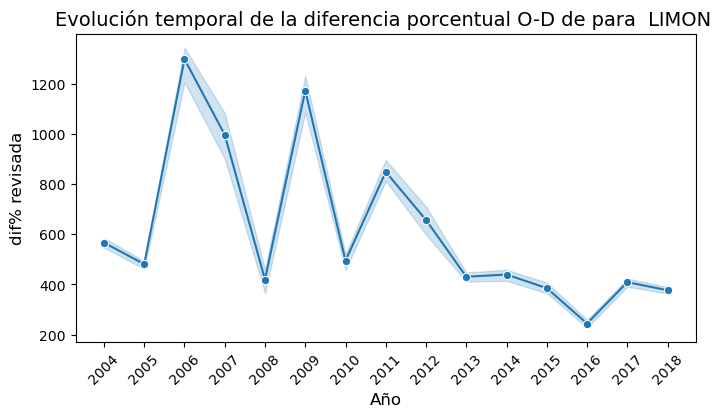

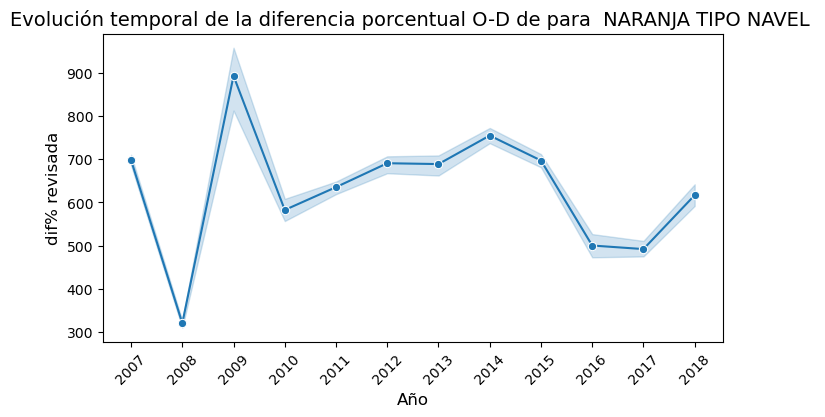

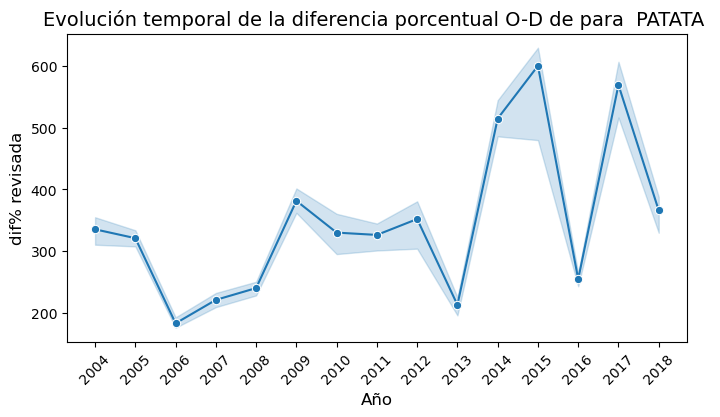

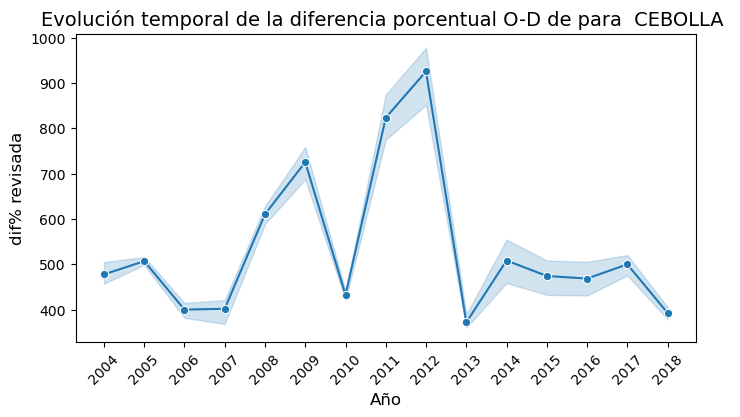

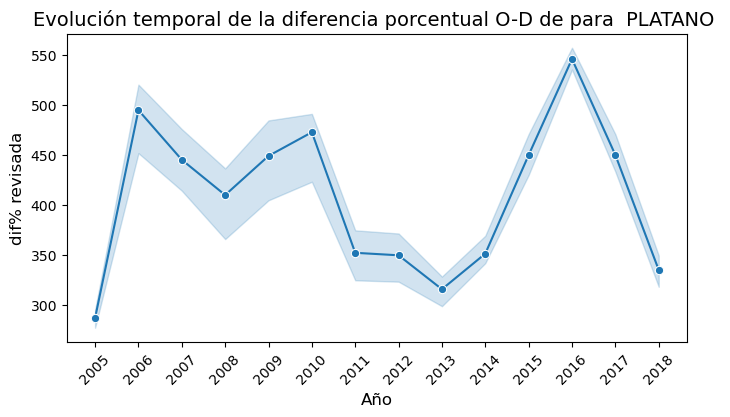

In [118]:
productos_top = (
    df_pivot.groupby('productos', as_index=False)['dif% revisada']
    .max()
    .sort_values(by='dif% revisada', ascending=False))

lista_productos_ordenados = productos_top['productos'].tolist()[:5]
for e in lista_productos_ordenados:
    grafico_alimento(e)

In [128]:
def grafico_grupo_alimento(grupo_alimentos):
    df_filtrado = df_pivot[df_pivot['productos'].isin(grupo_alimentos)]

    plt.figure(figsize=(8, 6))
    sns.lineplot(data=df_filtrado, x='YEAR', y='dif% revisada', hue='productos', marker='o',ci=40)

    plt.title("Evolución temporal de la diferencia porcentual O-D ", fontsize=14)
    plt.xlabel('Año', fontsize=12)
    plt.ylabel('dif% revisada', fontsize=12)
    plt.xticks(rotation=45)

    plt.legend(title='Producto')
    plt.show()

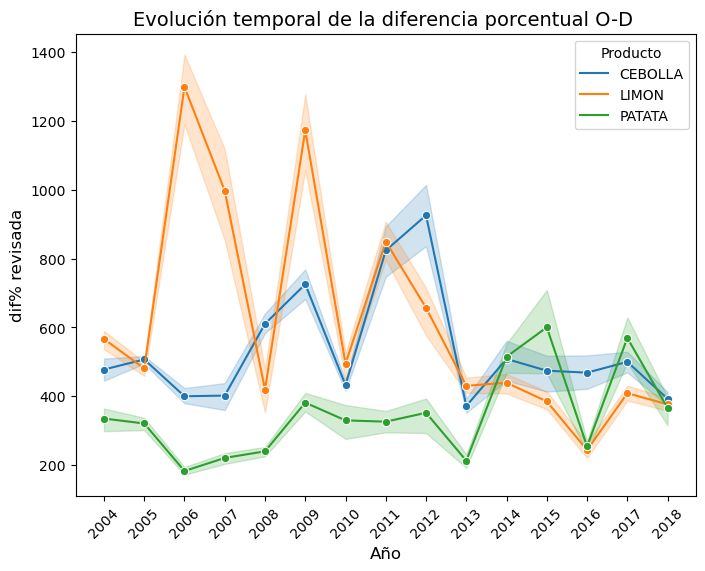

In [134]:
variables = ['CEBOLLA', 'PATATA', 'AJO', 'LIMON']
grafico_grupo_alimento(variables)